In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import glob
import time
import serial
import datetime as dt
from collections import deque, defaultdict

from collections import deque

class Lock:
    
    def __init__(self, timeout=None):
        self.queue = deque() # if multiple release requests, release to the first requester
        self.timeout = timeout
        
    def acquire(self, timeout=-1):
        if self.timeout: timeout = self.timeout # override with init timeout
        self.queue.append(threading.get_ident())
        termination = timeout*1e9 + time.time_ns()
        while timeout == -1 or time.time_ns() < termination:
            if self.queue and self.queue[0] == threading.get_ident(): break # acquired
            time.sleep(0.1) # determines lock query frequency
        else: # timed out
            return False
        return True
    
    def release(self):
        if self.queue and self.queue[0] == threading.get_ident():
            self.queue.popleft()
        else:
            raise Exception("Not the correct thread!")
        
    def release_all(self):
        self.queue.clear()
        
    def __enter__(self):
        self.acquire()
    
    def __exit__(self, *args):
        self.release()

%matplotlib notebook

# Boilerplate code for real-time graphs

def create_plot(*labels, history=100):
    import time
    
    # Create x-axis, data for history
    num_axes = len(labels)
    axes_data = [[] for _ in range(num_axes)]
    xs = list(range(history+1))
    
    # Hardcoded dimensions for axes 1 to 4
    PLOT_CONFIG = {
        1: [{"figsize":(6,4)}, {"shape":(1,1), "loc":[(0,0)], "colspan":[1]}],
        2: [{"figsize":(9,4)}, {"shape":(1,2), "loc":[(0,0),(0,1)], "colspan":[1,1]}],
        3: [{"figsize":(9,8)}, {"shape":(2,2), "loc":[(0,0),(0,1),(1,0)], "colspan":[1,1,2]}],
        4: [{"figsize":(9,8)}, {"shape":(2,2), "loc":[(0,0),(0,1),(1,0),(1,1)], "colspan":[1,1,1,1]}],
    }
    fig_config, ax_configs = PLOT_CONFIG[num_axes]
    fig = plt.figure(**fig_config)
    axs = []
    flags_yprecision = []
    for i in range(num_axes):
        shape, loc, colspan = ax_configs["shape"], ax_configs["loc"][i], ax_configs["colspan"][i]
        
        # Modify plot
        ax = plt.subplot2grid(shape, loc, colspan=colspan)
        ax.set_xlim([0,history])
        ax.grid()
        axs.append(ax)
        
        # Meta-settings
        flags_yprecision.append(True)
        ax.set_ylabel(labels[i])
    
    def get_global_max(data): return get_global_f(max, data)
    def get_global_min(data): return get_global_f(min, data)
    def get_global_f(f, data):
        if hasattr(data[0], "__len__"): # nested recursive search
            data = [get_global_f(f, lst) for lst in data]
        return f([v for v in data if v is not None])
    
    def catch_interrupt(f):
        # Wrap plotter with try-except to hide interrupt error message
        def helper(*ax_values):
            try:
                return f(*ax_values)
            except KeyboardInterrupt:
                pass
        return helper
            
    @catch_interrupt
    def plotter(*ax_values):
        # format: plotter([v1,v2],[v3]) for two axes
        if len(ax_values) != num_axes:
            
            # Special coercion for single axis only
            # format: plotter(v1,v2,v3)
            if num_axes == 1:
                ax_values = [ax_values]
            else:
                raise ValueError(
                    "Wrong number of axes - expected {}, provided {}".format(num_axes, len(ax_values)) + \
                    "\n  Check if number of axes is correct, i.e. create_plot('label1', 'label2') for two axes."
                )
        
        for j in range(num_axes):
            ax = axs[j]
            data = axes_data[j]
            values = ax_values[j]
            flag_yprecision = flags_yprecision[j]
            
            # Specially coerce single value into list
            if not hasattr(values, "__len__"):
                values = [values]
            
            # Initialize for first call
            if not data:
                init_ys = [None]*(history+1)
                for i in range(len(values)):
                    ys = deque(init_ys, maxlen=(history+1))
                    data.append(ys)
                    ax.plot(xs, ys)

            # Append new values
            assert len(values) == len(data)
            for i in range(len(values)):
                data[i].append(values[i])
                line = ax.lines[i]
                line.set_ydata(data[i])

            global_min, global_max = get_global_min(data), get_global_max(data)

            # Dynamically set y float format
            if global_max - global_min < 100:
                if not flag_yprecision:
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    flags_yprecision[j] = True
            else:
                if flag_yprecision:
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
                    flags_yprecision[j] = False

            # Dynamically set y range
            if global_min == global_max:
                global_max += 1
            if flag_yprecision:
                ax.set_ylim([global_min-0.01, global_max+0.01])
            else:
                ax.set_ylim([0.99*global_min, 1.01*global_max])
        
        # Draw
        plt.tight_layout()
        fig.canvas.draw()
        
    return plotter

In [ ]:
# also it's not exactly performant

# ==== Appended to plotter ====
# REMOVE THIS IN FUTURE ITERATIONS:
# - Not guaranteed to call a single plot function
#
# Dynamic sleep (in seconds)
# Sleep duration will be adjusted based on time elapsed between
# successive calls

def foo():
    # Dynamic sleep setting
    dynamic_sleep = None
    process_timing_start = None # code processing time delta
    
    def bar():
        nonlocal dynamic_sleep, process_timing_start
        if sleep:
            if dynamic_sleep:
                time.sleep(dynamic_sleep)

            # Otherwise, dynamic_sleep not initialized
            # This is branch to complete timing
            elif process_timing_start:
                process_timing = (time.time_ns() - process_timing_start)*1e-9
                dynamic_sleep = max(sleep - process_timing, 0)
                time.sleep(dynamic_sleep)

            # This is branch to start timing
            else:
                time.sleep(sleep)
                process_timing_start = time.time_ns()
                
"""1.2598984
2.268101
3.2886087
4.3074873
5.3323632000000005
6.341379000000001
7.3585038
8.375284500000001
9.3881507
10.4001318
11.4141095
12.429684100000001
13.444002800000002
14.448722600000002
15.456828300000002
16.4633706
17.4692086
18.4770463
19.485445900000002
20.4845428
21.4718048
22.4811488
23.4905185
24.514785900000003
25.5352123
26.562897300000003
27.5688366
28.5898071
29.610898700000003
30.6300054
31.640202300000002
32.664182700000005
33.6711404
34.6882607
35.698037400000004
36.7148598"""

In [1]:
import threading
import time
from IPython.display import display
import ipywidgets
 
output = ipywidgets.Output()
display(output)

# def monitor(items):
#     for item in items:
#         monitor.lock.acquire()
#         print(f"other thread: {item}\n")
#         monitor.lock.release()
#         time.sleep(1)
        
# monitor.lock = threading.Lock()
 
# thread = threading.Thread(target=monitor, args=([1,2,3,"HEY"],))
# thread.start()
# time.sleep(2)
# monitor.lock.acquire()
# print("Lock acquired.")
# time.sleep(3)
# print("Lock releasing...")
# monitor.lock.release()



def plot_threaded():
    plot = create_plot("Heater voltage (V)")
    start = time.time_ns()
    while plot_threaded.lock.acquire(timeout=10):
        heater_voltage = 10
        plot(heater_voltage)
        plot_threaded.lock.release()
        time.sleep(0.1)
    output.append_stdout("Time taken: {}s".format((time.time_ns()-start)*1e-9))
        
plot_threaded.lock = Lock()
# plot_threaded.lock = threading.Lock()

thread = threading.Thread(target=plot_threaded)
thread.start()

time.sleep(1)
plot_threaded.lock.acquire()
print("Acquired")
time.sleep(2)
print("Released")
plot_threaded.lock.release()

# Lock: Time taken: 7.8613938
# threading.Lock: Time taken: 7.704417

Output()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\users\administrator\appdata\local\programs\python\python38\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\administrator\appdata\local\programs\python\python38\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8/3332225783.py", line 60, in plot_threaded
NameError: name 'create_plot' is not defined


Acquired
Released


Output()

<IPython.core.display.Javascript object>


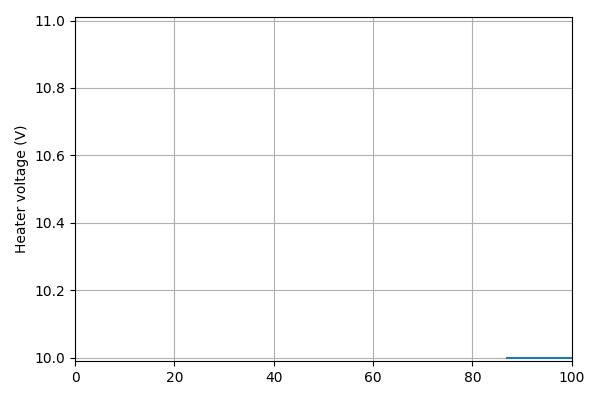

Acquired
Released


In [2]:
import threading
import time
from IPython.display import display
import ipywidgets
 
output = ipywidgets.Output()
display(output)

def plot_threaded():
    plot = create_plot("Heater voltage (V)")
    start = time.time_ns()
    while True:
        if plot_threaded.lock.acquire():
            heater_voltage = 10
            plot(heater_voltage)
            time.sleep(0.1)
            ok = True
            plot_threaded.lock.release()
        if ok:
            ok = False
            continue
        else:
            break
    output.append_stdout("Time taken: {}s".format((time.time_ns()-start)*1e-9))
        
plot_threaded.lock = Lock(timeout=3)
# plot_threaded.lock = threading.Lock()

thread = threading.Thread(target=plot_threaded)
thread.start()

time.sleep(1)
plot_threaded.lock.acquire()
print("Acquired")
time.sleep(2)
print("Released")
plot_threaded.lock.release()
time.sleep(1)
plot_threaded.lock.acquire()
time.sleep(4)
plot_threaded.lock.release()


In [ ]:
# Old format - single threaded
plot = create_plot("Heater voltage (V)")
while True:
    heater_voltage = 10 # query heater voltage
    plot(heater_voltage)
    time.sleep(0.1)

# Desired format - multi-threaded
plot = create_plot("Heater voltage (V)")
lock = Lock(timeout=1, timeout_call=lambda: plot.terminate()) # raises exception as well
while True:
    with lock:
        heater_voltage = 10 # query heater voltage
    plot(heater_voltage)
    time.sleep(0.1)
    
# Separate thread
with lock:
    heater_voltage = 5 # set heater voltage